In [3]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import sklearn as sk
from keras.layers import Dropout
from sklearn import metrics

In [5]:
# Считывание данных
weather_data = pd.read_csv('weather data chernov.csv')

weather_data = weather_data.rename(columns = {'time': 'Date'})
weather_data.Date = pd.to_datetime(weather_data.Date, format='ISO8601', errors='coerce')

In [7]:
generation_data = pd.read_excel("Данные ОИК ЧСЭС 01.05.2024 - 14.12.2024.xlsx")
new_column = generation_data.iloc[:,1] + generation_data.iloc[:,2]
generation_data = generation_data.drop(generation_data.columns[[1,2]], axis=1)
generation_data = generation_data.drop(0)
generation_data.insert(1, 'ПГБР Pген ГОУ Черновская', new_column)
columns_name = ['Date', 'Plan_X-1_Pgen', 'Fact_Pgen', 'Forecast_15_min', 'Forecast_30_min', 'Forecast_45_min', 'Forecast_60_min',
               'Forecast_2_hour', 'Forecast_3_hour', 'Forecast_4_hour', 'Insolation', "Temperature", 'Wind_speed']
generation_data.columns = columns_name
generation_data = generation_data.reset_index(drop=True)
generation_data.Date = pd.to_datetime(generation_data.Date)

Pgen = generation_data[['Date', 'Fact_Pgen']] # оставляю только дату для merge и генерацию

In [100]:
# using open-meteo weather data
data_merge = pd.merge(Pgen, weather_data, on='Date', how='left').drop_duplicates('Date') # Data merging
data = data_merge.drop('Date', axis=1) # после слияние дата не нужна
data = data.drop('shortwave_radiation_instant (W/m²)', axis=1) # shortwave is a sum of direct and diffuse radiation
data = data.dropna()
data['temperature_2m (°C)'] = data['temperature_2m (°C)'].astype(float) # was string format
data = data.reset_index(drop=True)

In [8]:
# using SO weather data
generation_data_weather = generation_data[['Fact_Pgen', 'Insolation', 'Temperature', 'Wind_speed']]
data = generation_data_weather.dropna()
data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')

C:\Users\evb36\AppData\Local\Temp\ipykernel_2484\3249728235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')


In [11]:
# Подготовка данных для LSTM
def prepare_data(series, look_back=4):
    """
    Метод разбивает полученные данные на последовательности с заданой величиной последовательности look_back
    В результает метод возвращает массив Х и у
    """
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series.iloc[i:i + look_back])  # Входные данные (последовательность)
        y.append(series.iloc[i + look_back, 0])  # Целевое значение (прогнозируем первый признак)
    return np.array(X), np.array(y)

# NN creating
def create_LSTM_model(n_features, LSTM_units=120, activation='relu', look_back=4, loss='mae', dropout=None, optimizer='adam'):
    """
    В методе собраны все шаги по построение LSTM. Возвращает скомпилированную модель
    """
    model = Sequential()
    model.add(LSTM(LSTM_units, activation=activation, input_shape=(look_back, n_features)))  # LSTM слой с 50 нейронами
    if dropout != None:
        model.add(Dropout(dropout)) # Вероятность отключения нейрона = значинию Dropout
    model.add(Dense(1))  # Выходной слой для прогнозирования одного значения
    # model compilating
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])  # Оптимизатор Adam и функция потерь MAE
    return model

def data_split_and_scaler(data, look_back=4, train_size_=0.8):
    """
    Метод разбивает получет данные data. В данных первый столбец - прогнозируемый признак.\n Метод разбивает полученные данные на последовательности с заданой величиной последовательности look_back.
    Затем данные маштабируются и формируются test и train массивы с заданной величиной тренировочного массива train_size_.\n Также метод возращает scaler для дальнейшего обратного преобразования.
    """
    X, y = prepare_data(data, look_back) # makes from data X and y arrays
    n_features = len(data.columns) #calculate count of features

    # Масштабирование данных (нормализация в диапазон [0, 1])
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X.reshape(-1, n_features)).reshape(X.shape[0], look_back, n_features)
    y = scaler.fit_transform(y.reshape(-1, 1))

    # Разделение данных на обучающую и тестовую выборки
    train_size = int(len(X) * train_size_)
    X_train, X_test = X[:train_size], X[train_size:] # данные должны бть последовательными, поэтому делю так
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

In [13]:
# Create train and test data
n_features = len(data.columns)
X_train, X_test, y_train, y_test, scaler = data_split_and_scaler(data, look_back=4, train_size_=0.8)

In [14]:
model = create_LSTM_model(n_features=n_features, LSTM_units=120, activation='relu', look_back=4, loss='mae', dropout=0.2, optimizer='adam')

C:\Users\evb36\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# # Обучение модели с кросс-валидацией
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)

# results_list = []
# # Кросс-валидация
# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     history = model.fit(X_train, y_train, epochs=8, validation_data=(X_test, y_test), verbose=0)
#     # model evaluating
#     results_list.append(model.evaluate(X_test, y_test, verbose=0))
# print (f'Mean loss on cross-validation is {np.mean(results_list)}')

In [17]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0851 - mse: 0.0242 - val_loss: 0.0341 - val_mse: 0.0040
Epoch 2/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0527 - mse: 0.0111 - val_loss: 0.0358 - val_mse: 0.0047
Epoch 3/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0481 - mse: 0.0101 - val_loss: 0.0360 - val_mse: 0.0054
Epoch 4/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0473 - mse: 0.0105 - val_loss: 0.0269 - val_mse: 0.0036
Epoch 5/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0455 - mse: 0.0100 - val_loss: 0.0250 - val_mse: 0.0032
Epoch 6/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0464 - mse: 0.0105 - val_loss: 0.0254 - val_mse: 0.0031
Epoch 7/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0451 - mse: 0.0098 - val_loss: 0.0240 - val_mse: 0.0031
Epoch 8/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0452 - mse: 0.0101 - val_loss: 0.0235 - val_mse: 0.0032
Epoch 9/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

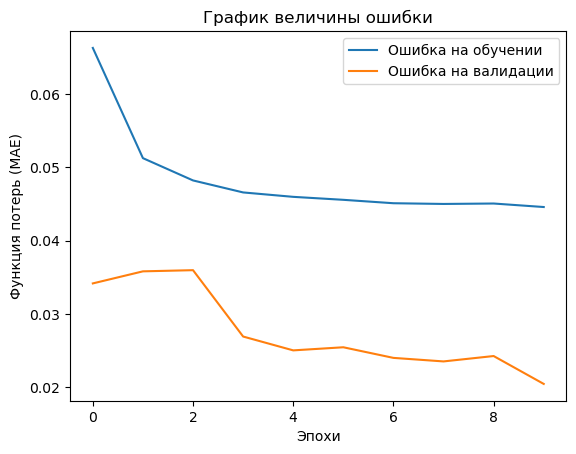

In [18]:
# Визуализация процесса обучения
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.title('График величины ошибки')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь (MAE)')
plt.legend()
plt.show()

In [19]:
# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Обратное масштабирование данных для сравнения с реальными значениями
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   


In [20]:
# Check the metrics on the deffined interval
mae = metrics.mean_absolute_error(y_test_original[150:200], y_pred_original[150:200])
# print(f"MSE на тестовых данных: {mse}")
mae

1.9526098459353665

In [28]:
# Check the metrics on the full test data
mae = metrics.mean_absolute_error(y_test_original, y_pred_original)
mse = metrics.mean_squared_error(y_test_original, y_pred_original)
# mape = metrics.mean_absolute_percentage_error(y_test_original, y_pred_original)
mae
# mse

0.6138490657192344

In [26]:
# diff = y_test_original - y_pred_original
# np.sort(diff)[:100]
# sorted(abs(diff), reverse=True)

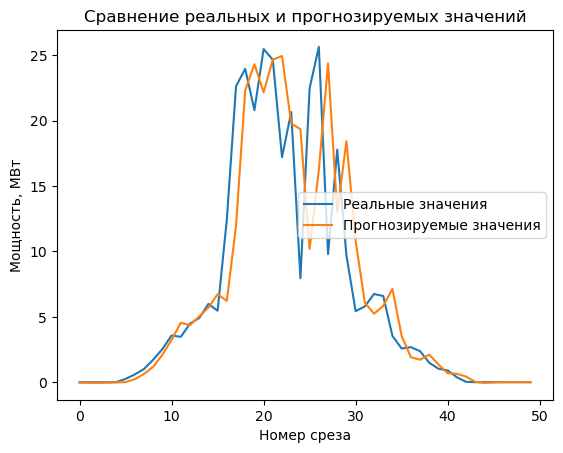

In [30]:
# Визуализация результатов
plt.plot(y_test_original[350:400], label='Реальные значения')
plt.plot(y_pred_original[350:400], label='Прогнозируемые значения')
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Номер среза')
plt.ylabel('Мощность, МВт')
plt.legend()
plt.show()